In [1]:
# All imports 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

Los Angeles Crime 2020 - Present
===================
This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data.
 
**`Acknowledgements:`**
 
Project idea from https://www.kaggle.com/datasets/chaitanyakck/crime-data-from-2020-to-present?select=Crime_Data_from_2020_to_Present.csv
 
Data Collection Source: https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
 
**`Project Goal`**
------------
Categorize the neighborhoods of Los Angeles by crime severity to know and predict which areas/municipalities are categorized as dangerous according to the FBI’s Uniform Crime Reporting (UCR) Program. Crime comparison amongst areas references the California crime levels
 
1. "Violent Crime is composed of four offenses: murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force." ("Crime in the United States")
    * 428 per 100,000 residents (Lofstrom and Martin)
 
2. "Property crime includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson." ("Crime in the United States")
    * 2,071 per 100,000 residents (Lofstrom and Martin)
 
*More information can be found at https://www.fbi.gov/services/cjis/ucr*

`References`

* Lofstrom and Martin. "Crime Trends in California." PPIC.org. Public Policy Institute of California. January 2022. https://www.ppic.org/publication/crime-trends-in-california/

* "2019 Crime in the United States." fbi.gov. Federal Bureau of Investigation. 2019. https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019
  
`Client Story:` A Los Angeles-based realtor wants to know which areas of Los Angeles to invest in (buy real estate). Since safety is a major concern for potential customers, the real estate agency wants to know the safest municipalities in the city to do business in. Thus, the real estate agency prefers to avoid areas of Los Angeles that may be risky to do business in. This ensures that the real estate investment is worthwhile in the long run and experience net gains. Areas with higher crime may scare away customers which could lead to a net loss of the investment. Market real estate price is not an issue to be wary of, the real estate agency solely wants to focus on the crime levels of the municipalities within the city.


Frame the Problem and Look at the Big Picture
=====================================
 
1. **Define the objective in business terms:**
Our client (the realtor based in Los Angeles), wants to know which areas of LA to invest in, based on the crime reports. Areas with higher crime rate and other determining factors are to be avoided, and areas with safer rates are much preferred.
 
2. **How will your solution be used?**
Our solution will be used in order to determine which areas of LA are the safest to invest into real-estate in that area. The results will not be a defined yes/no to invest in this area. The results will be used to assist the real estate agency into making their investment decision, potential crime is solely a factor of that decision. 

3. **What are current solutions (if any)?** Research crime data in the LA area. Results may vary, but there are plenty of research papers and other resources that study the crime levels of the city of Los Angeles. Sufficient research may indicate the areas of the city that face the most crime and ultimately affect the real estate market in an area.
 
4. **How should you frame this problem?** The problem is an unsupervised clustering problem since There isn't a label we can predict on. The clustering part comes in when having to separate the types of crimes, and we choose to define the threshold of what would be categorized as "dangerous." Furthermore, this problem is an offline learning system as identifying crime in an area is better suited to analyze over a period of time. Thus, we don't need to continuously update the program even though crime occurs very frequently. Important to also note that the data is updated weekly by the LAPD.
 
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
Because we are working with an unsupervised problem that is going to be used with clustering. We will have to try a variety of different clustering algorithms. What clustering method we use will depend on the results outputted by silhouette, adjusted rand score of a variety of clustering methods. 
 
6. **What would be the minimum performance needed to reach the business objective?**
Minimum performance depends on the metric we end up using dependent on the clustering algorithm. Based off prior assignments though, we think a minimum of .4 will be a good score to test the goodness of our clusters. 
 
7. **What are comparable problems? Can you reuse experience or tools?** We can look at project two for reference on clustering and performing optimization. A couple of in class examples further demonstrated the use of clustering, dimensionality reduction. In addition, we could also look at some visualization work done from the California housing dataset (state being the same was not on purpose). Furthermore, reference to ensembles can be looked at from project 1 in addition to the potential to use neural networks which we can reference recent class examples.
 
8. **Is human expertise available?** There is no human expertise available. All the data is gathered from the LAPD
 
9. **How would you solve the problem manually?** Survey the populace of Los Angeles. The survey asks what they think of the crime status of their municipality. Asking multiple questions about different crimes, their reoccurrence and rate their municipality from a range of 1 to 10. 1 meaning very safe, 10 meaning very dangerous. The ending score for each surveyor would be the average of their ratings. All the surveys would then be combined and averaged out. The results of the survey would indicate which areas to avoid solely based off human interpretation
 
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** The data is provided from the LAPD. We assume that the information provided is as accurate and objective as possible. We assume no corruption, and misleading reporting by law enforcement and any office involved in the gathering, preparation, and sharing of the data.

Get The Data
==================

1. **List the data you need and how much you need:** BELOW

2. **Find and document where you can get that data:** Data collected from Los Angeles open data catalog. Link provided in the `Acknowledgements:` section of project description

3. **Get access authorizations:** None needed. Data is open for developer use

4. **Create a workspace (with enough storage space):** This notebook

5. **Get the data:** BELOW

6. **Convert the data to a format you can easily manipulate (without changing the data itself):** data provided as CSV files.

7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done

8. **Check the size and type of data (time series, geographical, ...):** report of data available at the end of this section in markdown cell titled "summary"

In [32]:
# Read the data from the CSV File
data = pd.read_csv('Crime_Data_from_2020_to_Present.csv')


In [7]:
# A quick view of the features and samples
data

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,201220752,09/16/2020 12:00:00 AM,09/16/2020 12:00:00 AM,1230,12,77th Street,1259,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,NaN,NaN,NaN,700 E 73RD ST,NaN,33.9739,-118.2630
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326208,211208872,03/19/2021 12:00:00 AM,03/19/2021 12:00:00 AM,1105,12,77th Street,1218,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,58TH ST,FIGUEROA ST,33.9897,-118.2827
326209,210506531,03/04/2021 12:00:00 AM,03/04/2021 12:00:00 AM,2210,5,Harbor,564,2,434,FALSE IMPRISONMENT,...,AA,Adult Arrest,434.0,NaN,NaN,NaN,200 W 2ND ST,NaN,33.7424,-118.2814
326210,211710505,07/09/2021 12:00:00 AM,07/09/2021 12:00:00 AM,1050,17,Devonshire,1798,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,8800 DEMPSEY AV,NaN,34.2302,-118.4775
326211,210312887,07/12/2021 12:00:00 AM,07/12/2021 12:00:00 AM,1200,3,Southwest,363,1,350,"THEFT, PERSON",...,IC,Invest Cont,350.0,NaN,NaN,NaN,CRENSHAW BL,STOCKER ST,34.0088,-118.3351


In [10]:
# A further look into the features
data.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,3.262130e+05,326213.000000,326213.000000,326213.000000,326213.000000,326213.000000,326213.000000,326205.000000,119553.00000,326211.000000,26609.000000,908.000000,30.000000,326213.000000,326213.000000
mean,2.052169e+08,1352.350023,10.797191,1125.895866,1.413178,508.888843,30.071312,294.501176,362.48826,508.617787,955.472321,982.045154,989.866667,33.821225,-117.482054
std,4.993691e+06,650.308645,6.039220,604.029911,0.492405,210.392084,21.716913,213.084207,123.16658,210.180389,115.920942,53.442291,34.225150,2.916319,10.123197
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-1.000000,101.000000,101.00000,110.000000,210.000000,626.000000,821.000000,0.000000,-118.667600
25%,2.009170e+08,915.000000,6.000000,628.000000,1.000000,330.000000,12.000000,101.000000,308.00000,330.000000,998.000000,998.000000,998.000000,34.007800,-118.429600
50%,2.018168e+08,1430.000000,11.000000,1149.000000,1.000000,510.000000,31.000000,203.000000,400.00000,510.000000,998.000000,998.000000,998.000000,34.057400,-118.321400
75%,2.109007e+08,1900.000000,16.000000,1621.000000,2.000000,626.000000,45.000000,501.000000,400.00000,626.000000,998.000000,998.000000,998.000000,34.162800,-118.274000
max,2.199178e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,971.000000,516.00000,956.000000,999.000000,999.000000,999.000000,34.334300,0.000000


In [11]:
# Checking to see if there are missing values (There is in 18 features)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326213 entries, 0 to 326212
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           326213 non-null  int64  
 1   Date Rptd       326213 non-null  object 
 2   DATE OCC        326213 non-null  object 
 3   TIME OCC        326213 non-null  int64  
 4   AREA            326213 non-null  int64  
 5   AREA NAME       326213 non-null  object 
 6   Rpt Dist No     326213 non-null  int64  
 7   Part 1-2        326213 non-null  int64  
 8   Crm Cd          326213 non-null  int64  
 9   Crm Cd Desc     326213 non-null  object 
 10  Mocodes         281733 non-null  object 
 11  Vict Age        326213 non-null  int64  
 12  Vict Sex        283713 non-null  object 
 13  Vict Descent    283707 non-null  object 
 14  Premis Cd       326205 non-null  float64
 15  Premis Desc     326100 non-null  object 
 16  Weapon Used Cd  119553 non-null  float64
 17  Weapon Des

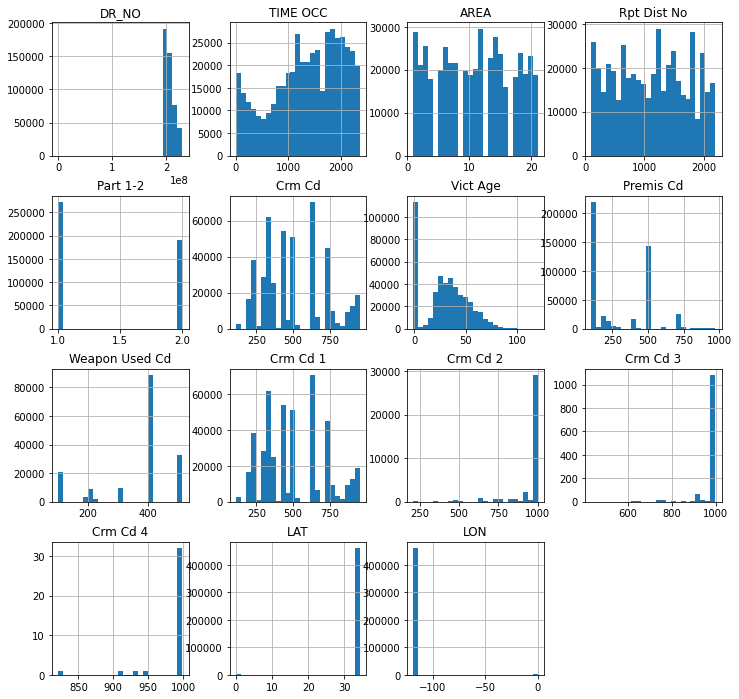

In [9]:
# Histogram of the data to see the distributions of features
data.hist(bins=25, figsize=(12, 12));


In [7]:
print(data['Vict Age'].value_counts()), print(data['Vict Age'].max())

 0      113074
 30      10652
 35      10223
 29      10166
 28      10073
         ...  
 96         42
 98         38
 97         31
-1          11
 120         1
Name: Vict Age, Length: 101, dtype: int64
120


(None, None)

In [39]:
(data['Date Rptd']).value_counts()

04/04/2022 12:00:00 AM    817
03/21/2022 12:00:00 AM    789
03/01/2022 12:00:00 AM    765
11/01/2021 12:00:00 AM    753
10/12/2021 12:00:00 AM    742
                         ... 
03/21/2020 12:00:00 AM    383
04/05/2020 12:00:00 AM    363
03/29/2020 12:00:00 AM    353
01/01/2020 12:00:00 AM    353
03/22/2020 12:00:00 AM    349
Name: Date Rptd, Length: 832, dtype: int64

In [37]:
pd.to_datetime(data['Date Rptd']).sort_values

<bound method Series.sort_values of 0        2020-01-08
1        2020-01-02
2        2020-01-01
3        2020-01-01
4        2020-01-02
            ...    
463366   2022-03-21
463367   2022-02-23
463368   2022-02-10
463369   2022-02-10
463370   2022-02-15
Name: Date Rptd, Length: 463371, dtype: datetime64[ns]>

Summary 
----------
1. There are 463371 samples of data

2. There are 28 features in the dataset

3. There is a lot of missing values from a couple of features in the data. These include: 
    * `Mocodes`, `Vict Sex`, `Vict Descent`, `Premis Cd`, `Premis Desc`, `Weapon Used Cd`, `Weapon Desc`, `Cross Street`

4. `Crm Cd 1` seems to only be missing 2 samples.  `Crm Cd 2`, `Crm Cd 3`, and `Crm Cd 4` have missing values because these only get added to if there are additional crimes to add

5. Through the initial analyzation of the data, we figured that there are a couple features that can be dropped. `Part 1-2` seems to provide us nothing in terms of what it provides. The description from where the data was gathered was empty, so we have even less idea of what it implies. `Dr No` also looks like it can be dropped. The other features look pretty important

6. What sick person committed a crime against a 120-year-old

7. `Date Rptd` and `DATE OCC` are awkward features since they also include a time along with the data the crime occurred. The time part of these features are always set to '12:00:00 AM'. What makes this part useless is that the feature `TIME OCC` exists which provides what time the crime occurred. With that discovery, we can manipulate the data by simply extracting the date from `Date Rptd` and `DATE OCC` and ignoring the '12:00:00 AM' part of these features.


Feature Definitions
------

* 17 Categorical Features
    * *`DR_NO`* - Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits

    * *`Date Rptd`* - Date reported

    * *`DATE OCC`* - Date occurred

    * *`TIME OCC`* - Time occurred in 24 hours military time

    * *`AREA NAME`* - The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles

    * *`Part 1-2`* - Not Defined from the data descriptions of the data provided

    * *`Vict Sex`* - F - Female M - Male X - Unknown

    * *`Vict Descent`* - Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian
    
    * *`Premis Desc`* - Defines the Premise Code provided

    * *`Weapon Desc`* - Defines the Weapon Used Code provided
    
    * *`Status`* - Status of the case. (IC is the default)

    * *`Status Desc`* - Defines the Status Code provided

    * *`LOCATION`* - Street address of crime incident rounded to the nearest a hundred block to maintain anonymity

    * *`Cross Street`* - Cross Street of rounded Address

    * *`LAT`* - Latitude

    * *`LON`* - Longitude

    * *`Crm Cd Desc`* - Defines the Crime Code provided

* 11 Numerical Features

    * *`AREA`* - The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21

    * *`Crm Cd`* - Indicates the crime committed. (Same as Crime Code 1)

    * *`Rpt Dist No`* - A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons

    * *`Mocodes`* - Modus Operandi: Activities associated with the suspect in commission of the crime

    * *`Vict Age`* - Two character numeric of the victims age

    * *`Premis Cd`* - The type of structure, vehicle, or location where the crime took place

    * *`Weapon Used Cd`* - The type of weapon used in the crime

    * *`Crm Cd 1`* - Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious

    * *`Crm Cd 2`* - May contain a code for an additional crime, less serious than Crime Code 1

    * *`Crm Cd 3`* - May contain a code for an additional crime, less serious than Crime Code 2

    * *`Crm Cd 4`* - May contain a code for an additional crime, less serious than Crime Code 3

Explore The Data
-------

In [42]:
# Copy of the data we can freshly explore on
copy = data.copy()

In [26]:
copy.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [ ]:
attrs = []

In [44]:
# Drop featues from copy dataset
copy.drop('DR_NO', inplace=True, axis=1)
copy.drop('Part 1-2', inplace=True, axis=1)

In [45]:
# don't overwhelm poor little human brains. Attempt to see any correlations among the data dataset
pd.plotting.scatter_matrix(copy, figsize=(18, 18), s=3, alpha=0.8);

<AxesSubplot:>

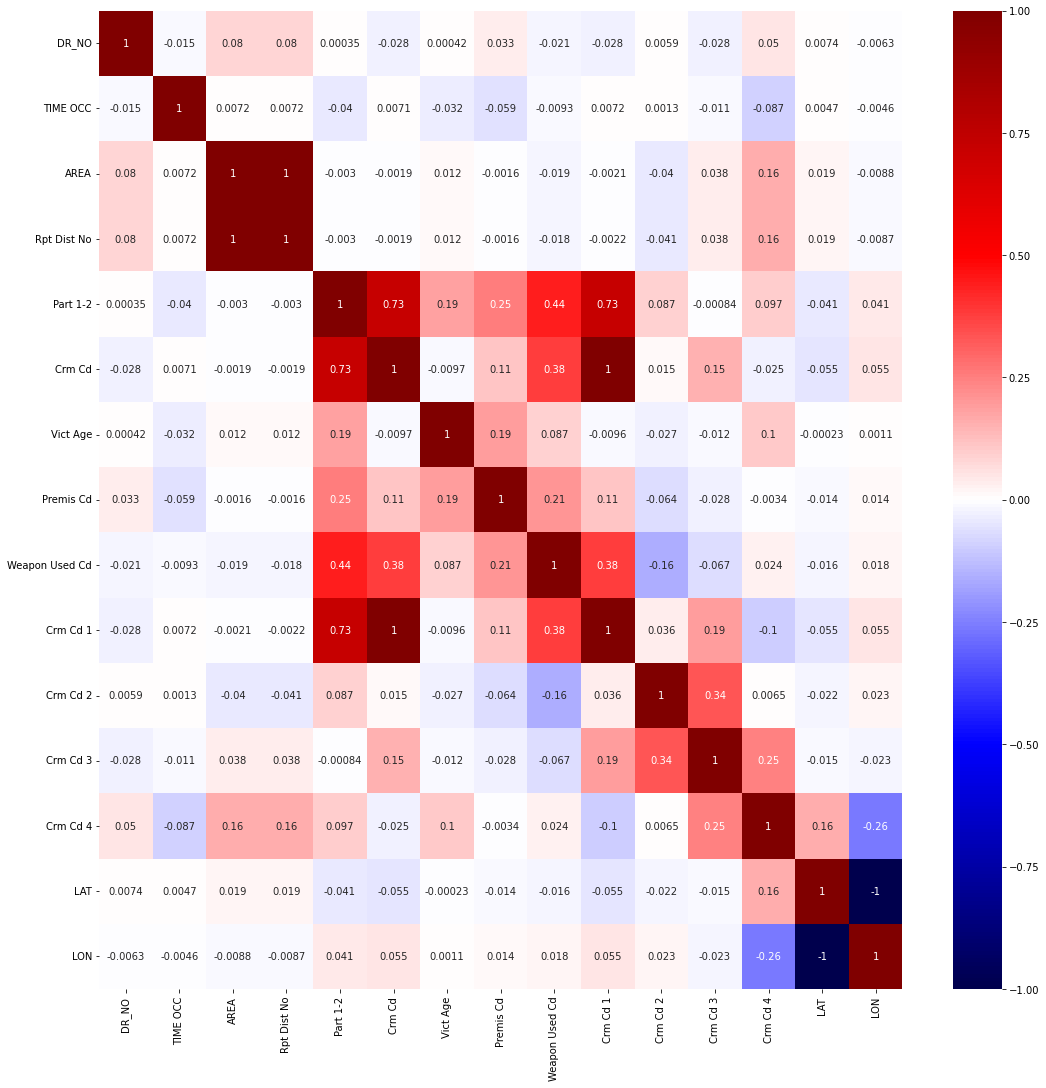

In [11]:
# view the linear correlations of the dataset
plt.figure(figsize=(18, 18))
sns.heatmap(copy.corr(), annot=True, vmin=-1, vmax=1, cmap='seismic')